<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_02_05_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Networks

## YouTube:
I explained this notebook in a [YouTube video](https://youtu.be/AWkPjrZshug).

## Acknowledgment:
I borrowed some code from [pytorch-geometric tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html).

## References:
```bibtex
@article{velickovic2018graph,
  title   ="{Graph Attention Networks}",
  author  ={Veli{\v{c}}kovi{\'{c}}, Petar and Cucurull, Guillem and Casanova, Arantxa and Romero, Adriana and Li{\`{o}}, Pietro and Bengio, Yoshua},
  journal ={International Conference on Learning Representations},
  year    ={2018},
  url     ={https://openreview.net/forum?id=rJXMpikCZ},
}
```

In [ ]:
# install pytorch_geometric
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Standard libraries
import numpy as np
from scipy import sparse
import seaborn as sns
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear

# PyTorch geometric
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import (GCNConv, GATConv)
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import (NormalizeFeatures, RandomNodeSplit)
from torch_geometric.data import Data
from torch_geometric import seed_everything

# scikit-learn
from sklearn.datasets import (make_blobs, make_circles)
from sklearn.manifold import TSNE

In [ ]:
random_seed = 42
torch.manual_seed(1234567)
seed_everything(42)
plt.style.use('dark_background')
accuracy_list = []

## Prepare a synthetic dataset

In [ ]:
X, y = make_blobs(n_samples=200, n_features=2, centers=1, cluster_std=0.15, random_state=random_seed)
# center at the origin
X = X - np.mean(X, axis=0)

X1, y1 = make_circles(n_samples=[600, 200], noise=0.04, factor=0.5, random_state=random_seed)
# add 1 to (make_circles) labels to account for (make_blobs) label
y1 = y1 + 1
# increase the radius
X1 = X1*3

X = np.concatenate((X, X1), axis=0)
y = np.concatenate((y, y1), axis=0)

In [ ]:
plot_colors = cm.tab10.colors
y_colors = np.array(plot_colors)[y]

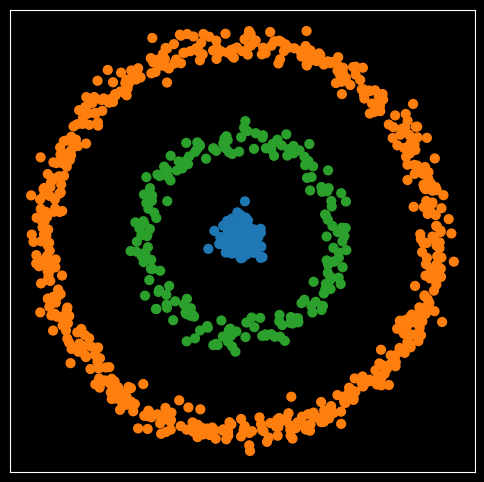

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(X[:,0], X[:,1], marker='o', s=40, color=y_colors)

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax.set(xlabel=None, ylabel=None)
plt.show()
# plt.axis('off')
# plt.savefig('plot.png', bbox_inches='tight', dpi=600, transparent=True)

## Adjacency matrix $A$
An $n \times n$ matrix, where each element represents the disance between a pair of samples. This is th formula to construct the adjacency matrix $A$:

$A_{ij}=exp(\frac{-\big\|s_i-s_j\big\|^2}{2{\sigma}^2})$

In [ ]:
# An n by n matrix, where each element represents the similarity between a pair of samples
sigma = 1
A = -1 * np.square(X[:, None, :] - X[None, :, :]).sum(axis=-1)
A = np.exp(A / (2* sigma**2))
np.fill_diagonal(A, 0)

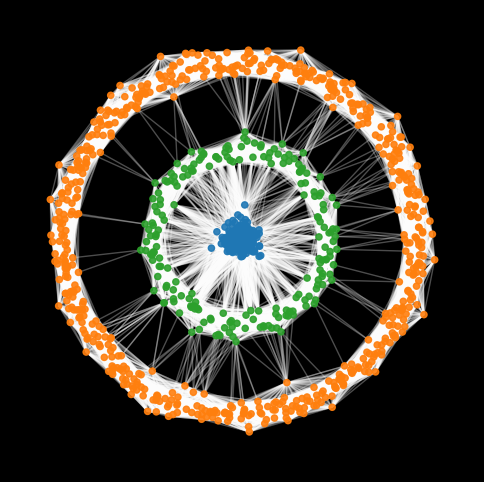

In [ ]:
# only keep edges with a value greater than 0.5
A1 = np.copy(A)
A1[A1 < 0.5] = 0
G = nx.from_numpy_array(A1)

plt.figure(figsize=(6,6))
plt.axis('off')
nx.draw_networkx_nodes(G, pos=X, node_size=20, node_color=y_colors, alpha=0.9)
nx.draw_networkx_edges(G, pos=X, edge_color="white", alpha=0.3)
plt.show()

In [ ]:
A = A1
num_features = X.shape[1]
num_classes = np.unique(y).shape[0]

# create an edge list out of the adjacency matrix
edge_index, _ = from_scipy_sparse_matrix(sparse.csr_matrix(A))
# create a torch_geometric Data instance
data_synthetic = Data(x=torch.from_numpy(X.astype(np.float32)), edge_index=edge_index, y=torch.from_numpy(y))
# create train/val/test masks with 80%/10%/10%
split = RandomNodeSplit(num_val=0.1, num_test=0.1)
data_synthetic = split(data_synthetic)
data_synthetic

Data(x=[1000, 2], edge_index=[2, 96996], y=[1000], train_mask=[1000], val_mask=[1000], test_mask=[1000])

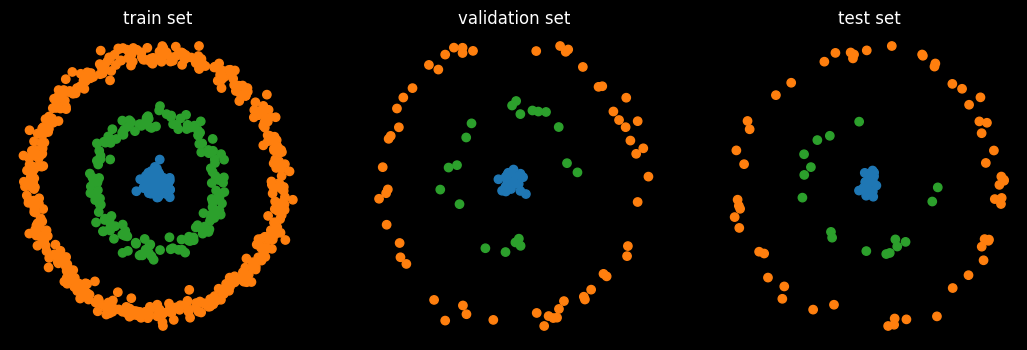

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
idxs = [data_synthetic.train_mask, data_synthetic.val_mask, data_synthetic.test_mask]
plt_label = ['train set', 'validation set', 'test set']
for i, idx in enumerate(idxs):
  axs[i].axis('off')
  axs[i].set_title(plt_label[i])
  axs[i].scatter(X[idx, 0], X[idx, 1], color=y_colors[idx])

plt.show()

In [ ]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(6,6))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color)
    plt.show()

## GAT

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads)
        self.conv2 = GATConv(hidden_channels*heads, num_classes, heads=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
model = GAT(hidden_channels=16, heads=8)
print(model)

GAT(
  (conv1): GATConv(2, 16, heads=8)
  (conv2): GATConv(128, 3, heads=1)
)


In [ ]:
def train(data, mask, GNN_flag):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      if GNN_flag:
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
      else:
        out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[mask], data.y[mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data, mask, GNN_flag):
      model.eval()
      if GNN_flag:
        out = model(data.x, data.edge_index)
      else:
        out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

## GAT Training

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(data_synthetic, data_synthetic.train_mask, GNN_flag=True)
    val_acc = test(data_synthetic, data_synthetic.val_mask, GNN_flag=True)
    test_acc = test(data_synthetic, data_synthetic.test_mask, GNN_flag=True)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['Graph Attention', 'synthetic', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.1698, Val: 0.3500, Test: 0.4000
Epoch: 002, Loss: 1.0466, Val: 0.3800, Test: 0.3100
Epoch: 003, Loss: 0.9916, Val: 0.4000, Test: 0.3200
Epoch: 004, Loss: 0.9634, Val: 0.4300, Test: 0.4400
Epoch: 005, Loss: 0.9252, Val: 0.5700, Test: 0.5700
Epoch: 006, Loss: 0.8980, Val: 0.5700, Test: 0.5700
Epoch: 007, Loss: 0.8641, Val: 0.5700, Test: 0.5700
Epoch: 008, Loss: 0.8719, Val: 0.5700, Test: 0.5700
Epoch: 009, Loss: 0.8649, Val: 0.5700, Test: 0.5700
Epoch: 010, Loss: 0.8515, Val: 0.5700, Test: 0.5700
Epoch: 011, Loss: 0.8204, Val: 0.5700, Test: 0.5700
Epoch: 012, Loss: 0.7960, Val: 0.5700, Test: 0.5700
Epoch: 013, Loss: 0.7629, Val: 0.5700, Test: 0.5700
Epoch: 014, Loss: 0.7652, Val: 0.5700, Test: 0.5700
Epoch: 015, Loss: 0.7117, Val: 0.5700, Test: 0.5700
Epoch: 016, Loss: 0.6850, Val: 0.5700, Test: 0.5700
Epoch: 017, Loss: 0.6720, Val: 0.5700, Test: 0.5700
Epoch: 018, Loss: 0.6302, Val: 0.6200, Test: 0.6000
Epoch: 019, Loss: 0.5999, Val: 0.7500, Test: 0.7400
Epoch: 020, 

NameError: name 'accuracy_list' is not defined

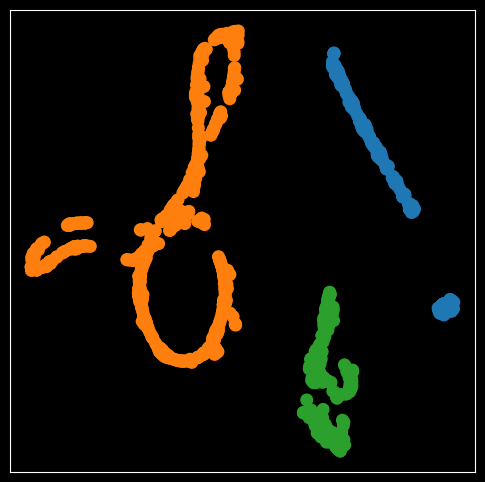

In [ ]:
model.eval()
out = model(data_synthetic.x, data_synthetic.edge_index)
visualize(out, y_colors)

## MLP

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [ ]:
model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=2, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=3, bias=True)
)


## MLP Training

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(data_synthetic, data_synthetic.train_mask, GNN_flag=False)
    val_acc = test(data_synthetic, data_synthetic.val_mask, GNN_flag=False)
    test_acc = test(data_synthetic, data_synthetic.test_mask, GNN_flag=False)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['MLP', 'synthetic', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.2843, Val: 0.5700, Test: 0.5700
Epoch: 002, Loss: 0.8114, Val: 0.5700, Test: 0.5700
Epoch: 003, Loss: 0.7912, Val: 0.5700, Test: 0.5700
Epoch: 004, Loss: 0.7876, Val: 0.5700, Test: 0.5700
Epoch: 005, Loss: 0.7133, Val: 0.5700, Test: 0.5700
Epoch: 006, Loss: 0.6740, Val: 0.5700, Test: 0.5700
Epoch: 007, Loss: 0.6271, Val: 0.7200, Test: 0.7500
Epoch: 008, Loss: 0.5931, Val: 0.7900, Test: 0.8300
Epoch: 009, Loss: 0.6023, Val: 0.8000, Test: 0.8300
Epoch: 010, Loss: 0.5770, Val: 0.8000, Test: 0.8300
Epoch: 011, Loss: 0.5484, Val: 0.8000, Test: 0.8400
Epoch: 012, Loss: 0.5211, Val: 0.8000, Test: 0.8300
Epoch: 013, Loss: 0.4944, Val: 0.8000, Test: 0.8300
Epoch: 014, Loss: 0.4954, Val: 0.8000, Test: 0.8300
Epoch: 015, Loss: 0.4935, Val: 0.8000, Test: 0.8300
Epoch: 016, Loss: 0.4691, Val: 0.8100, Test: 0.8300
Epoch: 017, Loss: 0.4689, Val: 0.8100, Test: 0.8500
Epoch: 018, Loss: 0.4512, Val: 0.8300, Test: 0.8800
Epoch: 019, Loss: 0.4412, Val: 0.8600, Test: 0.8900
Epoch: 020, 

In [ ]:
h = .05  # step size in the mesh
# create a mesh to plot decision boundary
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
plot_mesh = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()

# evaluate all the points in plot_mesh
model.eval()
out = model(plot_mesh)
pred = out.argmax(dim=1)  # Use the class with highest probability.
pred = pred.reshape(xx.shape).detach().numpy()


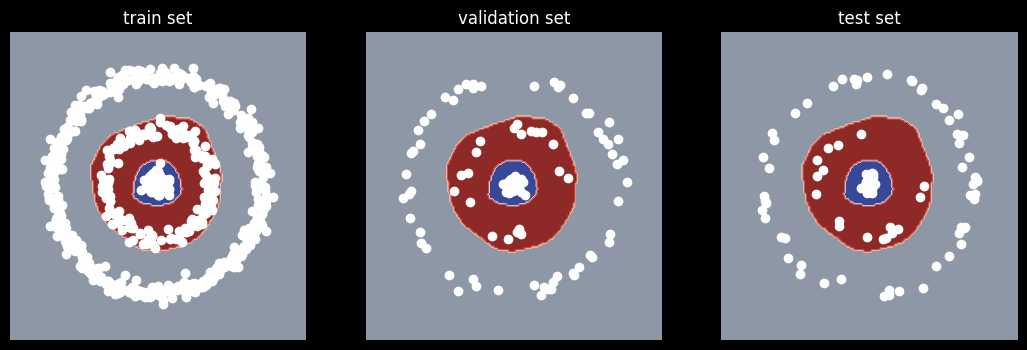

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
for i, idx in enumerate(idxs):
  axs[i].axis('off')
  axs[i].set_title(plt_label[i])
  axs[i].contourf(xx, yy, pred, cmap='coolwarm', alpha=0.7)
  axs[i].scatter(X[idx, 0], X[idx, 1], color='white')

plt.show()

## Prepare CORA dataset

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
num_features = dataset.num_features
num_classes = dataset.num_classes
data_Cora = dataset[0]  # Get the first graph object.
data_Cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

## GAT Training

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT(hidden_channels=16, heads=8)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(data_Cora, data_Cora.train_mask, GNN_flag=True)
    val_acc = test(data_Cora, data_Cora.val_mask, GNN_flag=True)
    test_acc = test(data_Cora, data_Cora.test_mask, GNN_flag=True)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['Graph Attention', 'CORA', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9447, Val: 0.5800, Test: 0.5750
Epoch: 002, Loss: 1.9083, Val: 0.7240, Test: 0.7380
Epoch: 003, Loss: 1.8711, Val: 0.7720, Test: 0.7960
Epoch: 004, Loss: 1.8295, Val: 0.7800, Test: 0.7930
Epoch: 005, Loss: 1.7900, Val: 0.7800, Test: 0.7850
Epoch: 006, Loss: 1.7366, Val: 0.7780, Test: 0.7710
Epoch: 007, Loss: 1.6899, Val: 0.7740, Test: 0.7630
Epoch: 008, Loss: 1.6323, Val: 0.7700, Test: 0.7650
Epoch: 009, Loss: 1.5739, Val: 0.7620, Test: 0.7740
Epoch: 010, Loss: 1.5187, Val: 0.7660, Test: 0.7780
Epoch: 011, Loss: 1.4497, Val: 0.7720, Test: 0.7820
Epoch: 012, Loss: 1.3831, Val: 0.7800, Test: 0.7930
Epoch: 013, Loss: 1.3151, Val: 0.7820, Test: 0.8010
Epoch: 014, Loss: 1.2442, Val: 0.7900, Test: 0.7980
Epoch: 015, Loss: 1.1767, Val: 0.7940, Test: 0.7960
Epoch: 016, Loss: 1.1104, Val: 0.7920, Test: 0.7930
Epoch: 017, Loss: 1.0282, Val: 0.7780, Test: 0.7930
Epoch: 018, Loss: 0.9613, Val: 0.7780, Test: 0.7940
Epoch: 019, Loss: 0.9120, Val: 0.7760, Test: 0.7960
Epoch: 020, 

## MLP Training

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(1, 201):
    loss = train(data_Cora, data_Cora.train_mask, GNN_flag=False)
    val_acc = test(data_Cora, data_Cora.val_mask, GNN_flag=False)
    test_acc = test(data_Cora, data_Cora.test_mask, GNN_flag=False)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

accuracy_list.append(['MLP', 'CORA', test_acc])

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9624, Val: 0.1620, Test: 0.1490
Epoch: 002, Loss: 1.9331, Val: 0.1200, Test: 0.1040
Epoch: 003, Loss: 1.8903, Val: 0.1620, Test: 0.1450
Epoch: 004, Loss: 1.8350, Val: 0.1800, Test: 0.1670
Epoch: 005, Loss: 1.7735, Val: 0.2120, Test: 0.2140
Epoch: 006, Loss: 1.6786, Val: 0.4280, Test: 0.4280
Epoch: 007, Loss: 1.5342, Val: 0.4380, Test: 0.4130
Epoch: 008, Loss: 1.4815, Val: 0.4480, Test: 0.4220
Epoch: 009, Loss: 1.3776, Val: 0.4740, Test: 0.4660
Epoch: 010, Loss: 1.2381, Val: 0.4520, Test: 0.4600
Epoch: 011, Loss: 1.1455, Val: 0.4820, Test: 0.4860
Epoch: 012, Loss: 1.0060, Val: 0.5060, Test: 0.5120
Epoch: 013, Loss: 0.9366, Val: 0.5380, Test: 0.5280
Epoch: 014, Loss: 0.7892, Val: 0.5560, Test: 0.5350
Epoch: 015, Loss: 0.8174, Val: 0.5180, Test: 0.5430
Epoch: 016, Loss: 0.6994, Val: 0.4940, Test: 0.5160
Epoch: 017, Loss: 0.6325, Val: 0.5280, Test: 0.5370
Epoch: 018, Loss: 0.7308, Val: 0.5500, Test: 0.5600
Epoch: 019, Loss: 0.6101, Val: 0.5500, Test: 0.5600
Epoch: 020, 

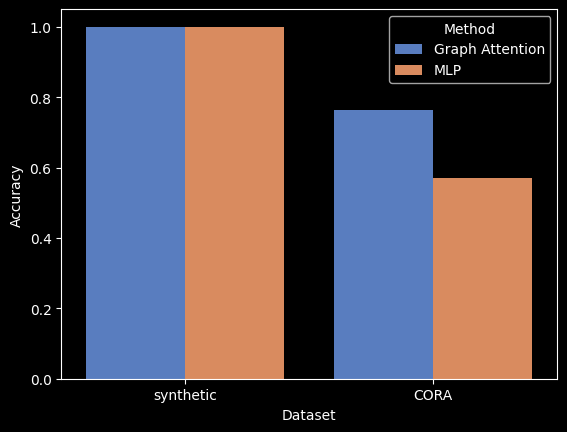

In [ ]:
df = pd.DataFrame(accuracy_list, columns=('Method', 'Dataset', 'Accuracy'))
sns.barplot(df,x='Dataset', y='Accuracy', hue='Method', palette="muted")
plt.show()